In [79]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import expm, eigh
from tqdm import tqdm
%matplotlib widget


# Electric field functions
def E_omega(t):
    return E0_au * np.exp(-((t-t0_au) / tau_au)**2) * np.cos(omega_au * t + phi1)

def E_2omega(t):
    return E02_au * np.exp(-((t-t0_au) / tau_au)**2) * np.cos(2*omega_au * t + phi2)
# Energies and dipole elements
omega_s_eV, omega_p_eV, omega_es_eV, omega_ep_eV, omega_ed_eV = -24.6, -3.4, 17.8, 17.8, 17.8
d_sp, d_pes, d_sep, d_ped = 0.45, 0.0001, 0.00002, 0.0001
omega_s, omega_p = omega_s_eV*0.0367493, omega_p_eV*0.0367493
omega_es, omega_ep, omega_ed = omega_es_eV*0.0367493, omega_ep_eV*0.0367493, omega_ed_eV*0.0367493

# Initial Hamiltonian without the field
H0 = np.array([
    [omega_s, 0, 0, 0, 0],
    [0, omega_p, 0, 0, 0],
    [0, 0, omega_es, 0, 0],
    [0, 0, 0, omega_ep, 0],
    [0, 0, 0, 0, omega_ed]
], dtype=complex)

# Define the decay term in atomic units
decay = 0.367493j  #1 eV is approximately 0.0367493 atomic units. Therefore, 10 eV is approximately 10 × 0.0367493 = 0.367493 atomic units.
# Introduce the decay term to the excited states
H0[2, 2] -= decay  # omega_es
H0[3, 3] -= decay  # omega_ep
H0[4, 4] -= decay  # omega_ed

print(H0)

# Hamiltonian function
def hamiltonian(t):
    E_om = E_omega(t)
    E_2om = E_2omega(t)
    return np.array([
        [0, d_sp * E_om, 0, d_sep * E_2om, 0],
        [d_sp * E_om, 0, d_pes * E_om, 0, d_ped * E_om],
        [0, d_pes * E_om, 0, 0, 0],
        [d_sep * E_2om, 0, 0, 0, 0],
        [0, d_ped * E_om, 0, 0, 0]
    ], dtype=complex)

# Time array(in fs)
start_time = -150 # fs
stop_time = 200 # fs

[[-0.90403278+0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.        +0.j      ]
 [ 0.        +0.j       -0.12494762+0.j        0.        +0.j
   0.        +0.j        0.        +0.j      ]
 [ 0.        +0.j        0.        +0.j        0.65413754-0.367493j
   0.        +0.j        0.        +0.j      ]
 [ 0.        +0.j        0.        +0.j        0.        +0.j
   0.65413754-0.367493j  0.        +0.j      ]
 [ 0.        +0.j        0.        +0.j        0.        +0.j
   0.        +0.j        0.65413754-0.367493j]]


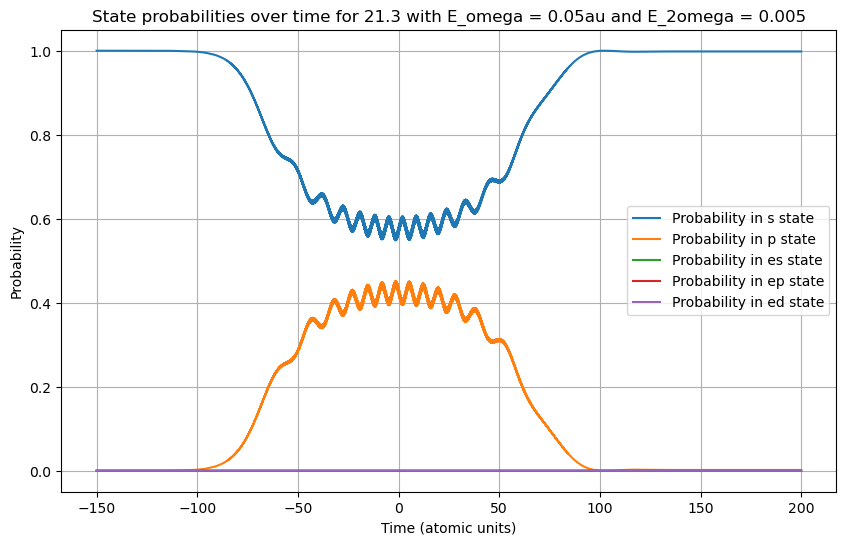

In [110]:

steps = 100000 # steps
t_values_SI = np.linspace(start_time, stop_time, steps)     # Time array in femtoseconds
t_values = t_values_SI*41 # Time array in atomic units
#print(f"Time array is from {t_values[0]} to {t_values[-1]} with {steps} steps")
dt = t_values[1] - t_values[0]
#print(f"Time step: {dt} au or {dt*0.0241888} fs")

# Electric Field
ϵ0 = 8.854187817e-12 # F/m
c = 3e8 # m/s
#E0_SI = 620 # V/m
#E0_au = E0_SI*5.14220652*10**-11
E0_au = 0.05
E02_au = 0.005
omega_eV = 21.3
omega_au = omega_eV*0.0367493
phi1 = 0.0
#phi2 = np.pi/2
phi2 = 0.0
tau = 50  # fs
tau_au = tau*41
t0 = 0 # fs
t0_au = t0*41

# Initial state
psi_0 = np.array([1, 0, 0, 0, 0], dtype=complex)
psi_t_list = [psi_0]

U0_half_dt = expm(-1j * H0 * dt / 2)
for index in range(len(t_values)-1):
    #Prepare the initial conditions for the current time step
    t = t_values[index] # Get the current time
    #print(f'time is {t} for index {index}')
    Hamil_t = hamiltonian(t) # Get the Hamiltonian at the current time
    #print(f'Hamil_t: {Hamil_t}')
    # Diagonalize the Hamiltonian
    eigenvalues, eigenvectors = eigh(Hamil_t)
    # Check if the eigenvectors are unitary(Unitary if UU^dagger = I)
    assert np.allclose(Hamil_t, Hamil_t.T.conj()), "Hamiltonian is not Hermitian"
    assert np.allclose(np.dot(eigenvectors.T.conj(), eigenvectors), np.eye(len(Hamil_t))), "Eigenvectors are not unitary"

    # Start of spil-operators method
    psi_dt = psi_t_list[index] # Get the wave function at the current time
    #print(f'psi_dt: {psi_dt}')
    psi_0_U0 = np.dot(U0_half_dt, psi_dt) # Step 0: Apply U0_half_dt to the wave function

    psi_0_eigenbasis = np.dot(eigenvectors.T.conj(), psi_0_U0) # Step 1: Transform the initial wave function to the eigenbasis
    #print(f'psi_0_eigenbasis: {psi_0_eigenbasis}')
    U_t = np.diag(np.exp(-1j * eigenvalues * dt ))
    #print(f'U_t: {U_t}')
    psi_t_eigenbasis = np.dot(U_t, psi_0_eigenbasis) # Step 2: Apply the diagonal matrix to the wave function in the eigenbasis
    #print(f'psi_t_eigenbasis: {psi_t_eigenbasis}')

    # Transform back to the original basis
    psi_t_pre = np.dot(eigenvectors, psi_t_eigenbasis) # Step 3: Transform the wave function back to the original basis
    #print(f'psi_t_pre: {psi_t_pre}')
    psi_t_U0 = np.dot(U0_half_dt, psi_t_pre) # Step 4: Apply U0_half_dt to the wave function
    #print(f'psi_t_U0: {psi_t_U0}')
    psi_t_list.append(psi_t_U0)  # Store the result
#print(f'psi_t_list: {psi_t_list}')

# Convert the list to a NumPy array for further processing
psi_t_array = np.array(psi_t_list)

df_psi = pd.DataFrame(psi_t_array, columns=['s', 'p', 'es', 'ep', 'ed'])
df_psi.to_csv(f'psi_t_{omega_eV}.csv', index=False)

prob_s = np.abs(np.array(psi_t_array)[:,0])**2
prob_p = np.abs(np.array(psi_t_array)[:, 1])**2
prob_es = np.abs(np.array(psi_t_array)[:, 2])**2
prob_ep = np.abs(np.array(psi_t_array)[:, 3])**2
prob_ed = np.abs(np.array(psi_t_array)[:, 4])**2

title = f"State probabilities over time for {omega_eV} with E_omega = {E0_au}au and E_2omega = {E02_au}"
plt.figure(figsize=(10, 6))
plt.plot(t_values_SI, prob_s, label='Probability in s state')
plt.plot(t_values_SI, prob_p, label='Probability in p state')
plt.plot(t_values_SI, prob_es, label='Probability in es state')
plt.plot(t_values_SI, prob_ep, label='Probability in ep state')
plt.plot(t_values_SI, prob_ed, label='Probability in ed state')
plt.title(title)
plt.xlabel('Time (atomic units)')
plt.ylabel('Probability')
plt.grid(which='both')

plt.legend()
#plt.savefig(f"{title}.png")
plt.show()

In [111]:
population_tot = []
for index in range(len(t_values)):
    total_population = prob_s[index] + prob_p[index] + prob_es[index] + prob_ep[index] + prob_ed[index]
    population_tot.append(total_population)

In [112]:
np.max(population_tot)

1.0

In [120]:
np.min(population_tot)

0.9999999272246328

In [113]:
np.min(prob_s)

0.5487634241687938

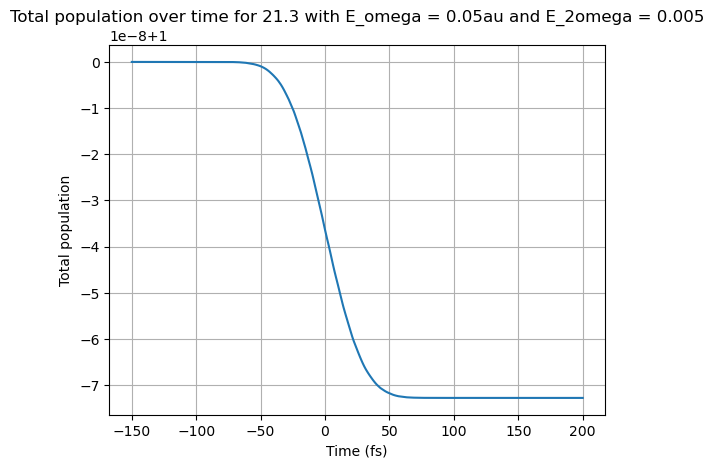

In [126]:
#%matplotlib widget
#plt.close()

#%matplotlib inline
title = f"Total population over time for {omega_eV} with E_omega = {E0_au}au and E_2omega = {E02_au}"
plt.plot(t_values_SI, population_tot)
#plt.plot(t_values_SI, prob_s)
#plt.ylim(np.min(population_tot), np.max(population_tot))
#plt.ylim(np.min(prob_s), np.max(prob_s))
plt.grid(True)
plt.title(title)
plt.xlabel('Time (fs)')
plt.ylabel('Total population')
plt.show()

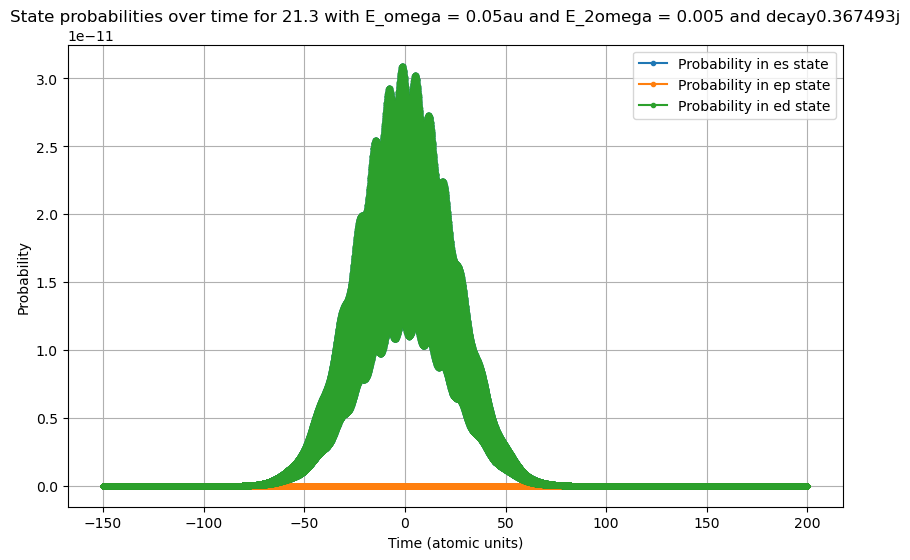

In [116]:
title = f"State probabilities over time for {omega_eV} with E_omega = {E0_au}au and E_2omega = {E02_au} and decay{decay}"
plt.figure(figsize=(10, 6))
#plt.plot(t_values_SI, prob_s, label='Probability in s state')
#plt.plot(t_values_SI, prob_p, label='Probability in p state')
plt.plot(t_values_SI, prob_es, marker = '.', label='Probability in es state')
plt.plot(t_values_SI, prob_ep, marker = '.', label='Probability in ep state')
plt.plot(t_values_SI, prob_ed, marker = '.', label='Probability in ed state')
plt.title(title)
plt.xlabel('Time (atomic units)')
plt.ylabel('Probability')
plt.grid(which='both')

plt.legend()
#plt.savefig(f"{title}_zoomed.png")
plt.show()

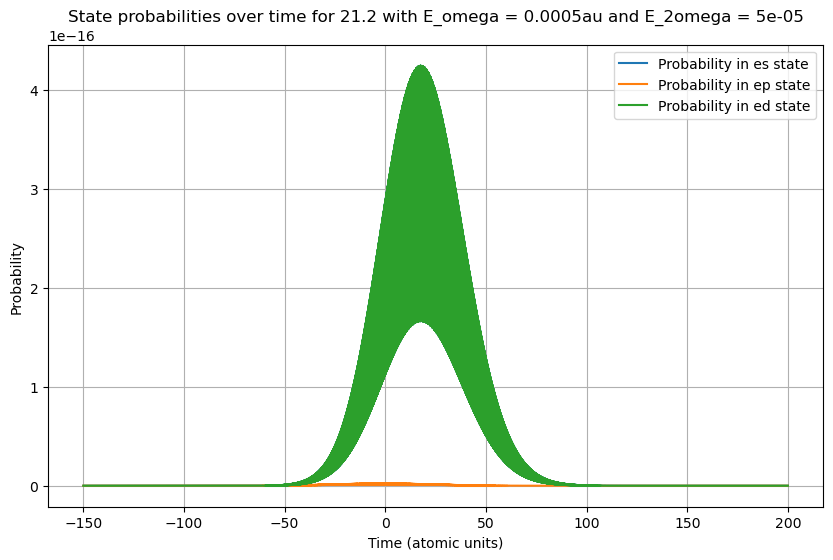

In [85]:
title = f"State probabilities over time for {omega_eV} with E_omega = {E0_au}au and E_2omega = {E02_au}"
plt.figure(figsize=(10, 6))
#plt.plot(t_values_SI, prob_s, label='Probability in s state')
#plt.plot(t_values_SI, prob_p, label='Probability in p state')
plt.plot(t_values_SI, prob_es, label='Probability in es state')
plt.plot(t_values_SI, prob_ep, label='Probability in ep state')
plt.plot(t_values_SI, prob_ed, label='Probability in ed state')
plt.title(title)
plt.xlabel('Time (atomic units)')
plt.ylabel('Probability')
plt.grid(which='both')

plt.legend()
#plt.savefig(f"{title}_zoomed.png")
plt.show()

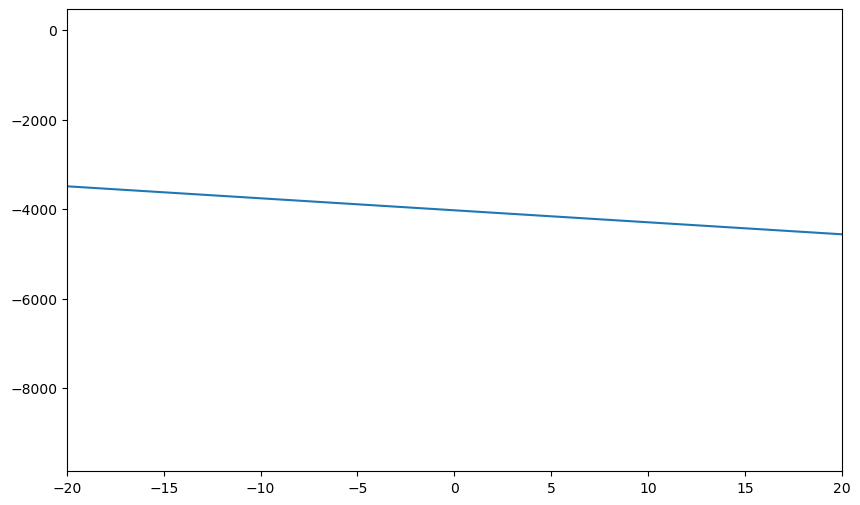

-0.4249907947481645


In [86]:
plt.figure(figsize=(10, 6))
plt.plot(t_values_SI, np.unwrap(np.angle(np.array(psi_t_array)[:, 3])))
plt.xlim(-20, 20)
plt.show()
print(np.angle(np.array(psi_t_array)[int((steps+1)/2), 3]))


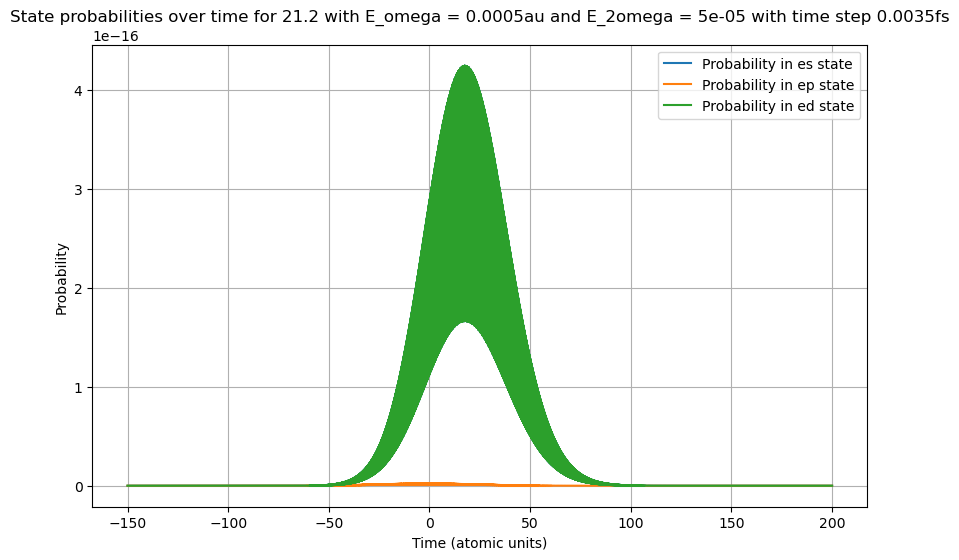

In [87]:
title = f"State probabilities over time for {omega_eV} with E_omega = {E0_au}au and E_2omega = {E02_au} with time step {round(dt/41, ndigits=6)}fs"
plt.figure(figsize=(10, 6))
#plt.plot(t_values_SI, prob_s, label='Probability in s state')
#plt.plot(t_values_SI, prob_p, label='Probability in p state')
plt.plot(t_values_SI, prob_es, label='Probability in es state')
plt.plot(t_values_SI, prob_ep, label='Probability in ep state')
plt.plot(t_values_SI, prob_ed, label='Probability in ed state')
plt.title(title)
plt.xlabel('Time (atomic units)')
plt.ylabel('Probability')
plt.grid(which='both')
plt.savefig(f"{title}.png")
plt.legend()
plt.show()